
# LangGraph: Financial Sections Pipeline (Minimal, No LLM → With LLM)

本 Notebook 在你已有的有向状态机结构上，接入了**实际 LLM（假设已配置 API Key）**：
- 使用占位模型名：`gpt-5-mini`（可在代码中修改）。
- 为每个 agent 设计了**任务定制 prompt**（Planner、BS/IS/CF Workers、各自 Checker、TotalChecker、Aggregator）。
- 加入**token 统计与费用估算**（`tiktoken` 不可用时会自动回退为 chars/4 近似）。
- 保留之前的**子图**封装与**并行→Join→总检→汇总**流程，以及冲突安全的 reducer 设计。
- 可视化使用 mermaid PNG，并展开子图。

> 说明：本 Notebook 的 LLM 调用使用 stub 文本作为 PDF 内容；你可以在 `readpdf_agent` 或外部注入真实文本与规则。


## 0) 环境配置、价格与 Token 统计工具

In [1]:

import os
from typing import List, Dict, Any, Optional, Tuple

# === 价格：按需要修改（$/1K tokens）===
PRICE_INPUT_PER_1K  = float(os.getenv("FINLLM_INPUT_PRICE_PER_1K", "0.05"))   # 示例：$0.05/1K
PRICE_OUTPUT_PER_1K = float(os.getenv("FINLLM_OUTPUT_PRICE_PER_1K", "0.15"))  # 示例：$0.15/1K

MODEL_NAME = os.getenv("FINLLM_MODEL", "gpt-5-mini")

# === Token 计数器（tiktoken 优先，失败则 chars/4）===
def _get_encoder():
    try:
        import tiktoken
        # 兜底选择一个通用 BPE；实际可换成与你的模型最接近的编码
        return tiktoken.get_encoding("cl100k_base")
    except Exception:
        return None

_ENCODER = _get_encoder()

def count_tokens(text: str) -> int:
    if not text:
        return 0
    if _ENCODER is not None:
        try:
            return len(_ENCODER.encode(text))
        except Exception:
            pass
    # fallback：粗略估计
    return max(1, int(len(text) / 4))

def estimate_cost(input_tokens: int, output_tokens: int) -> float:
    return (input_tokens/1000.0)*PRICE_INPUT_PER_1K + (output_tokens/1000.0)*PRICE_OUTPUT_PER_1K

# 全局用来累计各节点花费
COST_LOG: List[Dict[str, Any]] = []
def log_cost(node: str, role: str, in_tok: int, out_tok: int, prompt_preview: str, output_preview: str):
    COST_LOG.append({
        "node": node, "role": role,
        "input_tokens": in_tok, "output_tokens": out_tok,
        "input_cost": (in_tok/1000.0)*PRICE_INPUT_PER_1K,
        "output_cost": (out_tok/1000.0)*PRICE_OUTPUT_PER_1K,
        "total_cost": estimate_cost(in_tok, out_tok),
        "prompt_preview": prompt_preview[:200],
        "output_preview": output_preview[:200],
    })

def summarize_cost() -> Dict[str, Any]:
    total_in = sum(x["input_tokens"] for x in COST_LOG)
    total_out = sum(x["output_tokens"] for x in COST_LOG)
    return {
        "calls": len(COST_LOG),
        "input_tokens": total_in,
        "output_tokens": total_out,
        "est_cost": estimate_cost(total_in, total_out)
    }


## 1) LLM 客户端（OpenAI 兼容接口）

In [2]:

# 假设你已配置 OPENAI_API_KEY 或兼容环境变量
try:
    from openai import OpenAI
    from dotenv import load_dotenv
    load_dotenv()
    client = OpenAI()
    _USE_OPENAI = True
except Exception as e:
    print("OpenAI SDK 未就绪（将跳过真实请求，返回 stub 响应）。错误：", e)
    _USE_OPENAI = False

def call_llm(model: str, system: str, user: str) -> Tuple[str, int, int]:
    """Return (text, input_tokens, output_tokens). If SDK is unavailable, return a stub and estimated tokens."""
    prompt_for_count = f"[SYSTEM]\n{system}\n[USER]\n{user}"
    in_tok = count_tokens(prompt_for_count)
    if _USE_OPENAI:
        resp = client.chat.completions.create(
            model=model,
            messages=[{"role":"system","content":system},
                      {"role":"user","content":user}],
            temperature=1,
        )
        text = (resp.choices[0].message.content or "").strip()
        # 部分 SDK 提供用量字段；若无则估算
        out_tok = getattr(resp, "usage", None).completion_tokens if hasattr(resp, "usage") and resp.usage else count_tokens(text)
        in_tok  = getattr(resp, "usage", None).prompt_tokens     if hasattr(resp, "usage") and resp.usage else in_tok
        return text, in_tok, out_tok
    else:
        # stub 响应
        text = "【stub】此处返回模型输出（SDK 未就绪时的占位内容）。"
        out_tok = count_tokens(text)
        return text, in_tok, out_tok


## 2) 状态与 Reducer（与前版一致）

In [3]:

from typing import TypedDict
from typing_extensions import Annotated
from operator import or_ as dict_union
from langgraph.graph import StateGraph, START, END
from copy import deepcopy
from typing import List, Dict, Any

MAX_RETRIES = 2

def list_union(a: List[str] | None, b: List[str] | None) -> List[str]:
    a = a or []
    b = b or []
    seen = {}
    for x in a + b:
        if x not in seen:
            seen[x] = True
    return list(seen.keys())

def section_merge(a: Dict[str, Any] | None, b: Dict[str, Any] | None) -> Dict[str, Any]:
    a = a or {}
    b = b or {}
    va = a.get("_v", -1)
    vb = b.get("_v", -1)
    return a if va >= vb else b

class State(TypedDict, total=False):
    ctx: Annotated[dict, dict_union]                 # pdf_text 等共享只读
    tasks: Annotated[List[str], list_union]          # 任务列表
    bs: Annotated[Dict[str, Any], section_merge]     # balance sheet 命名空间
    inc: Annotated[Dict[str, Any], section_merge]    # income statement
    cf: Annotated[Dict[str, Any], section_merge]     # cash flows
    global_suggestions: Dict[str, Any]
    final_report: str

def log(msg: str): print(msg)

def merge(state: State, patch: Dict[str, Any]) -> State:
    s = deepcopy(state)
    s.update(patch)
    return s


## 3) 任务定制 Prompts（可按需微调）

In [4]:

# 这些是面向“规则+财报”任务设计的提示模板。
PLANNER_SYS = """\
You are the Planner Agent for a financial-report analysis DAG.
Decompose the task into explicit sections and steps, referencing any provided rules.
Only output a compact JSON with keys: tasks[].
"""

PLANNER_USER = """\
Context:
- Company document text is available in ctx.pdf_text (may be partial or noisy).
- User rulebase may be provided in 'rules' (JSON/YAML-like).

Goal:
Return a JSON listing which sections to work on, picked from: ["balance_sheet","income_statement","cash_flows"].
Example:
{"tasks": ["balance_sheet","income_statement","cash_flows"]}
"""

BS_SYS = """\
You are the Balance Sheet Worker. Extract and analyze the balance sheet.
Check asset/liability consistency, off-balance obligations, and working-capital changes.
Output concise markdown with key tables and bullet insights; keep units consistent.
"""

IS_SYS = """\
You are the Income Statement Worker. Focus on revenue quality, gross margin logic,
and alignment with receivables trends. Output concise markdown with key KPIs and commentary.
"""

CF_SYS = """\
You are the Cash Flows Worker. Reconcile Net Income vs CFO, highlight CapEx trends,
and non-cash adjustments. Output concise markdown with bullet points.
"""

# Local Checker prompts（每段独立）
BS_CHECKER_SYS = """\
You are the Balance Sheet Checker. Validate the BS draft against rules and accounting logic.
Return JSON: {"passed": bool, "feedback": [{"issue": str, "rule_id": str, "suggestion": str}]}
Keep feedback actionable and minimal.
"""

IS_CHECKER_SYS = """\
You are the Income Statement Checker. Validate the IS draft against rules.
Return JSON: {"passed": bool, "feedback": [{"issue": str, "rule_id": str, "suggestion": str}]}
"""

CF_CHECKER_SYS = """\
You are the Cash Flows Checker. Validate the CF draft against rules and reconciliations.
Return JSON: {"passed": bool, "feedback": [{"issue": str, "rule_id": str, "suggestion": str}]}
"""

# Global checker & aggregator
TOTAL_CHECKER_SYS = """\
You are the Global Consistency Checker. Verify cross-statement consistency
(BS vs IS vs CF), terminology normalization, and surface doc-wide red flags.
Return JSON: {"suggestions": [{"area": str, "action": str}]}
"""

AGGREGATOR_SYS = """\
You are the Aggregator/Synthesizer. Merge validated sections into an
investor-facing brief with a short executive summary, a compact KPI table,
a risk flags list, and the global suggestions. Output markdown only.
"""


## 4) 顶层节点（Reader / Planner / TotalChecker / Aggregator）- 带 LLM 与记账

In [5]:

def readpdf_agent(state: State) -> State:
    log("→ ReadPDFAgent")
    ctx = dict(state.get("ctx", {}))
    # 实际项目里这里放真实抽取；此处用 stub
    ctx.update({"pdf_text": "Dummy PDF text with tables & figures about a fictional company FY2024."})
    return merge(state, {"ctx": ctx})

def planner_agent(state: State) -> State:
    log("→ PlannerAgent (LLM)")
    # 根据 ctx/rules 生成 tasks
    user = "Rules: (none for demo)\nPlease propose tasks."
    text, in_tok, out_tok = call_llm(MODEL_NAME, PLANNER_SYS, PLANNER_USER + "\n" + user)
    log_cost("Planner", "planner", in_tok, out_tok, PLANNER_USER, text)
    # 简单解析（若失败则兜底）
    import json
    tasks = ["balance_sheet","income_statement","cash_flows"]
    try:
        j = json.loads(text)
        if isinstance(j, dict) and isinstance(j.get("tasks"), list) and j["tasks"]:
            tasks = [t for t in j["tasks"] if t in {"balance_sheet","income_statement","cash_flows"}]
    except Exception:
        pass
    return merge(state, {"tasks": tasks})

def total_checker(state: State) -> State:
    log("→ TotalChecker (LLM)")
    user = f"Drafts summary:\nBS:{state.get('bs',{}).get('draft','')}\nIS:{state.get('inc',{}).get('draft','')}\nCF:{state.get('cf',{}).get('draft','')}"
    text, in_tok, out_tok = call_llm(MODEL_NAME, TOTAL_CHECKER_SYS, user)
    log_cost("TotalChecker", "global_checker", in_tok, out_tok, TOTAL_CHECKER_SYS, text)
    # 尝试解析
    import json
    suggestions = []
    try:
        j = json.loads(text)
        suggestions = j.get("suggestions", [])
    except Exception:
        suggestions = [{"area":"normalization","action":"ensure units and terminology are consistent"}]
    return merge(state, {"global_suggestions": {"items": suggestions, "raw": text}})

def aggregator(state: State) -> State:
    log("→ Aggregator (LLM)")
    user = f"""Inputs (validated):
- Balance Sheet:
{state.get('bs', {}).get('draft', '<none>')}

- Income Statement:
{state.get('inc', {}).get('draft', '<none>')}

- Cash Flows:
{state.get('cf', {}).get('draft', '<none>')}

- Global Suggestions: {state.get('global_suggestions', {})}
"""
    text, in_tok, out_tok = call_llm(MODEL_NAME, AGGREGATOR_SYS, user)
    log_cost("Aggregator", "synthesizer", in_tok, out_tok, AGGREGATOR_SYS, text)
    return merge(state, {"final_report": text})



## 5) 子图：三个并行分支（BS/IS/CF）— Worker + Checker + Join（带 LLM 与记账）

In [6]:

def build_sections_subgraph() -> StateGraph:
    sg = StateGraph(State)

    # Workers
    def balance_sheet_worker(state: State) -> State:
        log("→ [Sub] BalanceSheetWorker (LLM)")
        user = f"ctx.pdf_text sample: {state.get('ctx',{}).get('pdf_text','<none>')}"
        text, in_tok, out_tok = call_llm(MODEL_NAME, BS_SYS, user)
        log_cost("BS_Worker", "worker", in_tok, out_tok, BS_SYS, text)
        bs = dict(state.get("bs", {}))
        r = bs.get("retries", 0)
        bs.update({"draft": text, "_v": bs.get("_v", 0) + 1, "retries": r})
        return merge(state, {"bs": bs})

    def income_statement_worker(state: State) -> State:
        log("→ [Sub] IncomeStatementWorker (LLM)")
        user = f"ctx.pdf_text sample: {state.get('ctx',{}).get('pdf_text','<none>')}"
        text, in_tok, out_tok = call_llm(MODEL_NAME, IS_SYS, user)
        log_cost("IS_Worker", "worker", in_tok, out_tok, IS_SYS, text)
        inc = dict(state.get("inc", {}))
        r = inc.get("retries", 0)
        inc.update({"draft": text, "_v": inc.get("_v", 0) + 1, "retries": r})
        return merge(state, {"inc": inc})

    def cash_flows_worker(state: State) -> State:
        log("→ [Sub] CashFlowsWorker (LLM)")
        user = f"ctx.pdf_text sample: {state.get('ctx',{}).get('pdf_text','<none>')}"
        text, in_tok, out_tok = call_llm(MODEL_NAME, CF_SYS, user)
        log_cost("CF_Worker", "worker", in_tok, out_tok, CF_SYS, text)
        cf = dict(state.get("cf", {}))
        r = cf.get("retries", 0)
        cf.update({"draft": text, "_v": cf.get("_v", 0) + 1, "retries": r})
        return merge(state, {"cf": cf})

    # Checkers
    import json
    def bs_checker(state: State) -> State:
        log("→ [Sub] BSChecker (LLM)")
        draft = dict(state.get("bs", {})).get("draft","")
        text, in_tok, out_tok = call_llm(MODEL_NAME, BS_CHECKER_SYS, draft)
        log_cost("BS_Checker", "local_checker", in_tok, out_tok, BS_CHECKER_SYS, text)
        fb = {"passed": True, "feedback": []}
        try:
            fb = json.loads(text)
        except Exception:
            pass
        bs = dict(state.get("bs", {}))
        r = bs.get("retries", 0)
        if not fb.get("passed", False):
            bs.update({"passed": False, "feedback": fb.get("feedback", []), "retries": r + 1, "_v": bs.get("_v", 0) + 1})
        else:
            bs.update({"passed": True, "feedback": fb.get("feedback", []), "_v": bs.get("_v", 0) + 1})
        return merge(state, {"bs": bs})

    def is_checker(state: State) -> State:
        log("→ [Sub] ISChecker (LLM)")
        draft = dict(state.get("inc", {})).get("draft","")
        text, in_tok, out_tok = call_llm(MODEL_NAME, IS_CHECKER_SYS, draft)
        log_cost("IS_Checker", "local_checker", in_tok, out_tok, IS_CHECKER_SYS, text)
        fb = {"passed": True, "feedback": []}
        try:
            fb = json.loads(text)
        except Exception:
            pass
        inc = dict(state.get("inc", {}))
        r = inc.get("retries", 0)
        if not fb.get("passed", False):
            inc.update({"passed": False, "feedback": fb.get("feedback", []), "retries": r + 1, "_v": inc.get("_v", 0) + 1})
        else:
            inc.update({"passed": True, "feedback": fb.get("feedback", []), "_v": inc.get("_v", 0) + 1})
        return merge(state, {"inc": inc})

    def cf_checker(state: State) -> State:
        log("→ [Sub] CFChecker (LLM)")
        draft = dict(state.get("cf", {})).get("draft","")
        text, in_tok, out_tok = call_llm(MODEL_NAME, CF_CHECKER_SYS, draft)
        log_cost("CF_Checker", "local_checker", in_tok, out_tok, CF_CHECKER_SYS, text)
        fb = {"passed": True, "feedback": []}
        try:
            fb = json.loads(text)
        except Exception:
            pass
        cf = dict(state.get("cf", {}))
        r = cf.get("retries", 0)
        if not fb.get("passed", False):
            cf.update({"passed": False, "feedback": fb.get("feedback", []), "retries": r + 1, "_v": cf.get("_v", 0) + 1})
        else:
            cf.update({"passed": True, "feedback": fb.get("feedback", []), "_v": cf.get("_v", 0) + 1})
        return merge(state, {"cf": cf})

    # Join
    def join_barrier(state: State) -> State:
        log("→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)")
        return state

    def join_route(state: State):
        bs_passed = dict(state.get("bs", {})).get("passed")
        inc_passed = dict(state.get("inc", {})).get("passed")
        cf_passed = dict(state.get("cf", {})).get("passed")
        if bs_passed and inc_passed and cf_passed:
            return "go"
        return "wait"

    # Wire subgraph
    sg.add_node("BS_Worker", balance_sheet_worker)
    sg.add_node("IS_Worker", income_statement_worker)
    sg.add_node("CF_Worker", cash_flows_worker)
    sg.add_node("BS_Checker", bs_checker)
    sg.add_node("IS_Checker", is_checker)
    sg.add_node("CF_Checker", cf_checker)
    sg.add_node("Join", join_barrier)

    sg.add_edge(START, "BS_Worker")
    sg.add_edge(START, "IS_Worker")
    sg.add_edge(START, "CF_Worker")

    sg.add_edge("BS_Worker", "BS_Checker")
    sg.add_edge("IS_Worker", "IS_Checker")
    sg.add_edge("CF_Worker", "CF_Checker")

    def route_bs(state: State):
        bs = dict(state.get("bs", {}))
        if bs.get("passed"): return "done"
        if bs.get("retries", 0) >= MAX_RETRIES:
            bs.update({"passed": True, "_v": bs.get("_v", 0) + 1})
            return "done"
        return "retry"

    def route_is(state: State):
        inc = dict(state.get("inc", {}))
        if inc.get("passed"): return "done"
        if inc.get("retries", 0) >= MAX_RETRIES:
            inc.update({"passed": True, "_v": inc.get("_v", 0) + 1})
            return "done"
        return "retry"

    def route_cf(state: State):
        cf = dict(state.get("cf", {}))
        if cf.get("passed"): return "done"
        if cf.get("retries", 0) >= MAX_RETRIES:
            cf.update({"passed": True, "_v": cf.get("_v", 0) + 1})
            return "done"
        return "retry"

    sg.add_conditional_edges("BS_Checker", route_bs, {"retry":"BS_Worker", "done":"Join"})
    sg.add_conditional_edges("IS_Checker", route_is, {"retry":"IS_Worker", "done":"Join"})
    sg.add_conditional_edges("CF_Checker", route_cf, {"retry":"CF_Worker", "done":"Join"})

    sg.add_conditional_edges("Join", join_route, {"wait":"Join", "go": END})

    return sg


## 6) 父图装配与编译

In [7]:

# Build parent graph
parent = StateGraph(State)
parent.add_node("ReadPDF", readpdf_agent)
parent.add_node("Planner", planner_agent)

sections_subgraph = build_sections_subgraph().compile()
parent.add_node("Sections", sections_subgraph)

parent.add_node("TotalChecker", total_checker)
parent.add_node("Aggregator", aggregator)

parent.add_edge(START, "ReadPDF")
parent.add_edge("ReadPDF", "Planner")
parent.add_edge("Planner", "Sections")
parent.add_edge("Sections", "TotalChecker")
parent.add_edge("TotalChecker", "Aggregator")
parent.add_edge("Aggregator", END)

app = parent.compile()
print("Parent graph compiled with subgraph node 'Sections'.")


Parent graph compiled with subgraph node 'Sections'.


## 7) 可视化（展开子图的 Mermaid PNG）

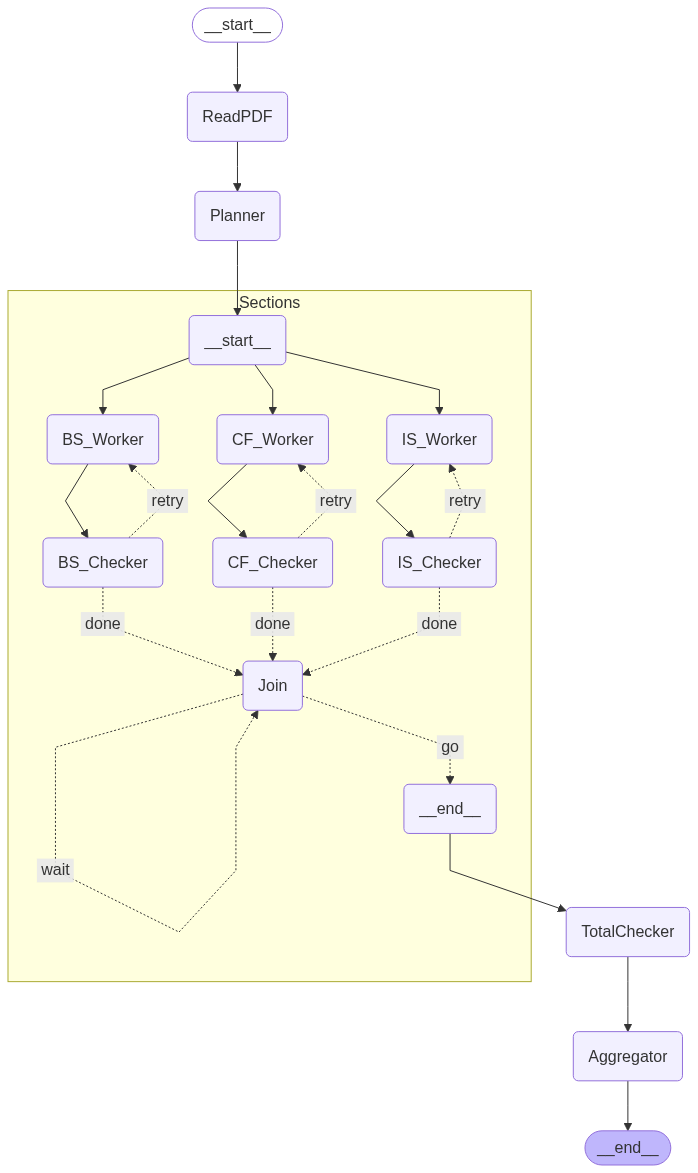

In [8]:

from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Mermaid 生成失败（可忽略）：", e)


## 8) 试跑 & 费用汇总

In [9]:

initial_state: State = {}
final_state = app.invoke(initial_state)

print("\n=== Final Report (markdown) ===\n")
print(final_state.get("final_report","<no report>"))

print("\n=== Cost Items ===")
for item in COST_LOG:
    print(item["node"], item["role"], "→",
          f"in={item['input_tokens']}, out={item['output_tokens']},",
          f"cost=${item['total_cost']:.4f}")

print("\n=== Total Cost Summary ===")
print(summarize_cost())


→ ReadPDFAgent
→ PlannerAgent (LLM)
→ [Sub] BalanceSheetWorker (LLM)
→ [Sub] CashFlowsWorker (LLM)
→ [Sub] IncomeStatementWorker (LLM)
→ [Sub] BSChecker (LLM)
→ [Sub] ISChecker (LLM)
→ [Sub] CFChecker (LLM)
→ [Sub] BalanceSheetWorker (LLM)→ [Sub] CashFlowsWorker (LLM)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)

→ [Sub] BSChecker (LLM)→ [Sub] CFChecker (LLM)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)

→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for BS/IS/CF passed)
→ [Sub] JoinBarrier (waiting for

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT